<h1 align="center"><font face = "Times New Roman" size = "80">JPEG Compression</font></h1>
<h2 align="center"><font face = "Times New Roman" size = ""> Information theory and coding</font></h2>
<h3 align="center"><font face = "Times New Roman"> Fall 2019</font></h3>
<h6 align="center"><font face = "Times New Roman"">Alaa Mohamed Roshdy&nbsp 201600031</font></h6>
<h6 align="center"><font face = "Times New Roman">Mohamed Adham Mahrous&nbsp 201601078</font></h6>
<h6 align="center"><font face = "Times New Roman">Mohamed Mostafa Hamed&nbsp 201600236</font></h6>
<h6 align="center"><font face = "Times New Roman">Mohamed Kasem Saber&nbsp 201601144</font></h6>




---




## Introduction

JPEG compression is one of the most frequently used compressions for images. In this project, we implement JPEG and JPEG 2000 compression and compare different compression types together. 
For JPEG, we use 2 different block sizes for compression. Namely, 8x8 and 16x16. Furthermore, different quantization tables were used. Low quantization table ranges its values from 1-16, and high quantization table ranges its values from 1-256.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
from PIL import Image
from encoder import reshape_image
from encoder_2000 import check_image
import main as m
import main_2000 as m2

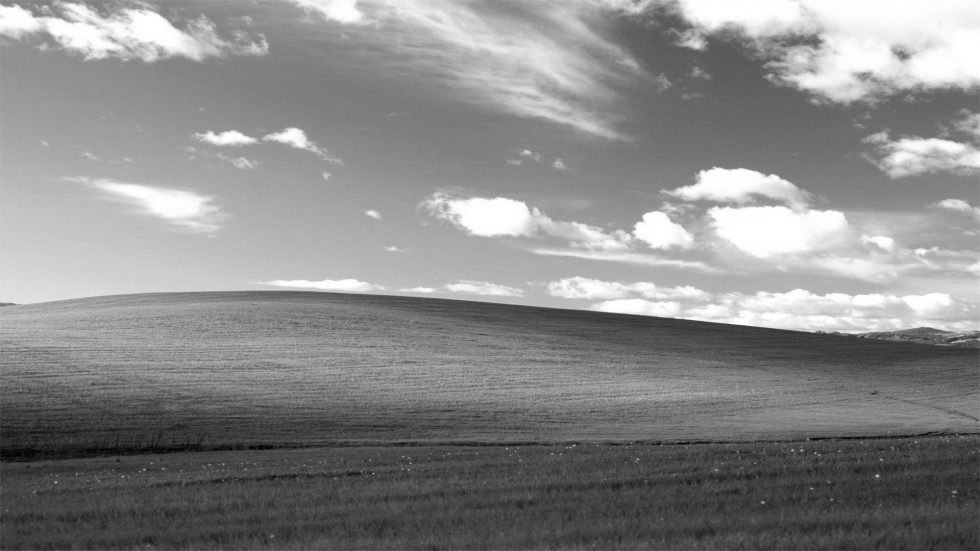

In [2]:
# Display the image

im = Image.open('images/landscape2.jpg')
im = im.convert("L")
im

In [3]:
def rmse(im, reconstructed_image):
    """
    Gets the root mean squared error between 2 images
    Args:
         im (numpy array) : The original image
         reconstructed_image (numpy ndarray): The reconstructed image
    Returns:
        rmse: root mean squared error as a metric to compare between the original image and the reconstructed
    """
    error = im - reconstructed_image
    mse = np.sum(np.square(error)) / (im.shape[0] * im.shape[1])
    rmse = np.sqrt(mse)

    return rmse




---


<h2 align="center"><font face = "Times New Roman">JPEG compression</font></h3>


In the following 4 blocks of code, we repeatedly encode and decode the image according to the given block size and quantization table. The huffman encoded sequence is saved in *encoded* array to be later used in computing the compression ratio. All reconstructed images are saved in reconstructed array, and the execution time for each compression type is saved in *execution_time* array.

To encode and decode, 2 main functions in main.py were utilized; namely, encode() and decode(). Both functions arrange all encoder.py and decoder.py functions sequentially in the following way: 
![jpeg pipeline diagram](images/JPEG_diagram.png)


In [4]:
# Define block size
box_size = 8
encoded = [] # An array containing all 4 huffcodes resulting from the encoding process
reconstructed = [] # Array containing all 4 reconstructed images
execution_time = [] # Execution time for each compression

start = timeit.default_timer()
# Apply 8 x 8 compression using low compression quantization table

huffcoded, code_dict, n_rows, n_columns = m.encode(im, box_size, m.table_8_low)
encoded.append(huffcoded)
reconstructed.append( m.decode(huffcoded, code_dict,  n_rows, n_columns, box_size, m.table_8_low))
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[0])

Execution time:  22.43144509600097


In [5]:
box_size = 8

start = timeit.default_timer()
# Apply 8 x 8 compression using high compression quantization table

huffcoded, code_dict, n_rows, n_columns = m.encode(im, box_size, m.table_8_high)
encoded.append(huffcoded)
reconstructed.append( m.decode(huffcoded, code_dict,  n_rows, n_columns, box_size, m.table_8_high) )
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[1])

Execution time:  9.40342530199996


In [6]:
box_size = 16

start = timeit.default_timer()
# Apply 16 x 16 compression using low compression quantization table

huffcoded, code_dict, n_rows, n_columns = m.encode(im, box_size, m.table_16_low)
encoded.append(huffcoded)
reconstructed.append( m.decode(huffcoded, code_dict,  n_rows, n_columns, box_size, m.table_16_low))
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[2])

Execution time:  12.632475672999135


In [7]:
box_size = 16

start = timeit.default_timer()
# Apply 16 x 16 compression using high compression quantization table

huffcoded, code_dict, n_rows, n_columns = m.encode(im, box_size, m.table_16_high)
encoded.append(huffcoded)
reconstructed.append( m.decode(huffcoded, code_dict,  n_rows, n_columns, box_size, m.table_16_high))
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[3])

Execution time:  8.154236509000839





---


<h2 align="center"><font face = "Times New Roman">Comparison</font></h2>
<h3 align="left"><font face = "Times New Roman">Qualitative comparison</font></h2>


When zoomed in, we can see the clear difference between each resulting image, especially in edges with high contrast. 16x16 compression yields pixelated images that are clearer to see than 8x8 compression and larger in size. Furthermore, we can see clear difference between high compression and low compression in both block sizes. High compression yielded more 'noisy' image than low compression

Text(0.5, 1.0, '16x16 high compression')

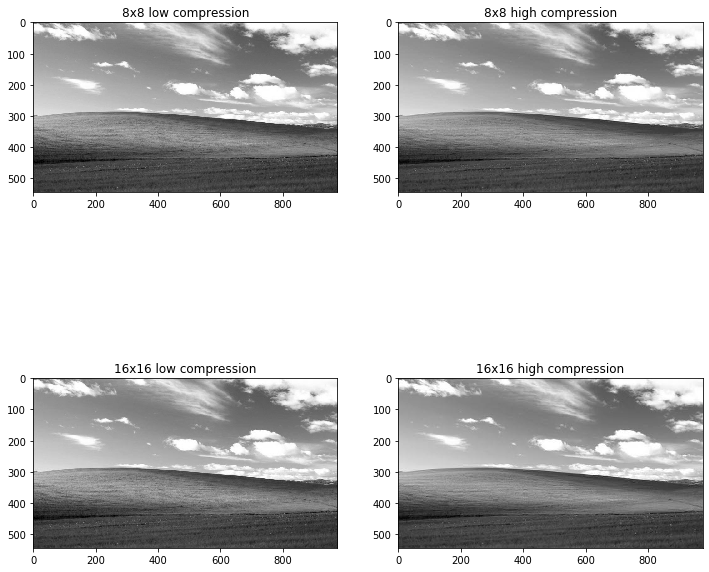

In [8]:
f, axarr = plt.subplots(2,2, figsize = (12,12))
axarr[0,0].imshow(reconstructed[0], cmap = "gray")
axarr[0,0].set_title("8x8 low compression")
axarr[0,1].imshow(reconstructed[1], cmap = "gray")
axarr[0,1].set_title("8x8 high compression")
axarr[1,0].imshow(reconstructed[2], cmap = "gray")
axarr[1,0].set_title("16x16 low compression")
axarr[1,1].imshow(reconstructed[3], cmap = "gray")
axarr[1,1].set_title("16x16 high compression")

<h3 align="left"><font face = "Times New Roman">Quantitative comparison</font></h2>

The table below shows quantitative analysis of the resulting reconstructed images. As expected, 8x8 compression results in lower root mean squared error than 16x16 compression and lower compression ratio. This is due to the fact that less data is lost in 8x8 compression. It retains more information. Also, we can notice that the number of floating point operations is significantly lower for 16x16 compression blocks. High compression yields greater compression ratio compared to low compression in both 8x8 and 16x16 blocks. It also yields higher RMSE. This is expected since more data is lost when higher compression type is used. It corresponds to a quantization table that has large values, which zeros out all high frequency components in the image. Moreover, # of flops in high compression is almost half of that in low compression (for both 8x8 and 16x16 blocks). This is due to the fact that run-length encoding takes significantly shorter time to decode highly compressed images compared to low compressed images; there are more zeros in highly compressed images. 

In [10]:
# Amount of compression achieved
imarr = reshape_image(im)

#Compute the number of bits of the np array image
size_before = imarr.size * imarr.itemsize * 8 
print("Size in bits of image before compression: ", size_before)

# Number of bits in encoded is the length of encoded. Each element in the string corresponds to a bit in reality.

size_after = []
for i in range(len(encoded)):
    size_after.append(len(encoded[i]))

##################################################

# Number of floating point operations

#Dummy operation to measure the time for a single operation
start = timeit.default_timer()
x = 2837*3847
stop = timeit.default_timer()
single_FLOP = stop - start

##################################################


# Quality of compressed image (RMSE)

rms_error =[]
for i in range(len(reconstructed)):
    if(i > 1):
        #Then reconstructed image is based on 16x16 compression,
        #Therefore, the image should be compared with the reshaped image having
        #box_size 16
        imarr = reshape_image(im,16)
    rms_error.append(rmse(imarr, reconstructed[i]))


# Print results
comp_type = ["8x8 low", "8x8 high", "16x16 low", "16x16 high",]
# intialise data of lists.
data = {'compression type':comp_type,
        'size in bits': size_after,
        'compression ratio':[size_before/x for x in size_after] ,
        "# of flops": [t/single_FLOP for t in execution_time],
        'RMSE': rms_error}
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
print(df)

Size in bits of image before compression:  4247552
  compression type  size in bits  compression ratio     # of flops      RMSE
0          8x8 low        871895           4.871632  865196.409732  1.688771
1         8x8 high        314948          13.486518  188198.880803  4.136271
2        16x16 low        508191           8.358180  300834.833428  2.370692
3       16x16 high        165740          25.627803  166956.560151  4.528649




---


<h2 align="center"><font face = "Times New Roman">JPEG2000 compression</font></h3>


In [3]:
# Define quantization tables and DWT decomposition levels

# LL, LL
levels = [
             [0, #LL 
                 [[0]] #LL again
             ]
        ]

## LL block will be quantized by 2s, LH by 2s, HL by 3 and HH by 4.
quantization_Array = [1, 2, 3, 4]


encoded = [] # An array containing all 4 huffcodes resulting from the encoding process
reconstructed = [] # Array containing all 4 reconstructed images
execution_time = [] # Execution time for each compression

start = timeit.default_timer()
# Apply the the decomposition stated in levels, and perform [2,2,3,4] quantization on it. 

huffcoded, code_dict, length, aspect_ratio = m2.encode(im, levels, quantization_Array)
encoded.append(huffcoded)
reconstructed.append( m2.decode( huffcoded, code_dict, length, quantization_Array, aspect_ratio) )
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[0])


Execution time:  39.54832351500045


In [10]:
Image.fromarray(reconstructed[0]).size, im.size

((976, 544), (980, 551))

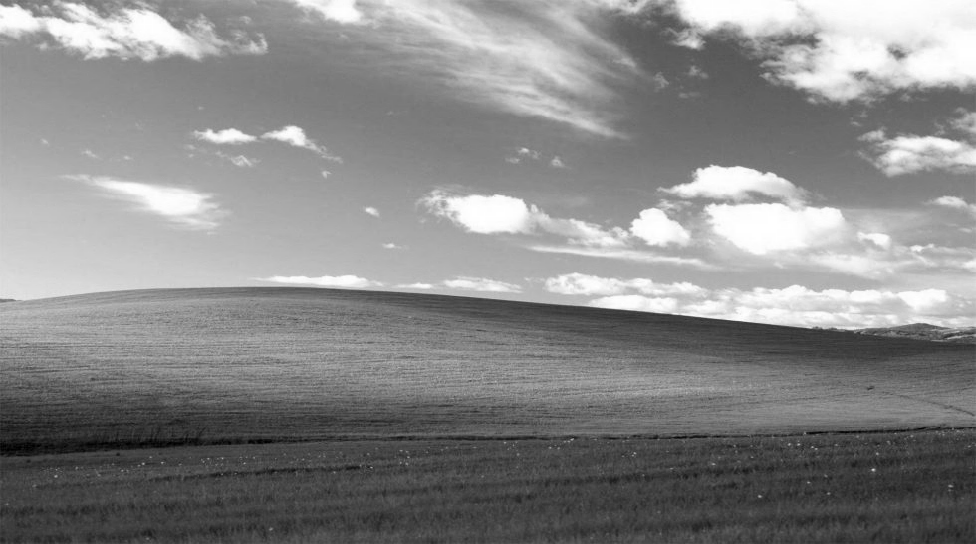

In [9]:
Image.fromarray(reconstructed[0])

In [11]:
quantization_Array = [4, 4, 5, 6]

start = timeit.default_timer() 
#LL, LL with quantization [4, 4, 5, 6]

huffcoded, code_dict, length = m2.encode(im, levels, quantization_Array)
encoded.append(huffcoded)
reconstructed.append( m2.decode( huffcoded, code_dict, length, quantization_Array) )
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[1])


Execution time:  6.394583358998716


In [14]:
levels = [[1,[[0]]]]

## LL block will be quantized by 2s, LH by 2s, HL by 3 and HH by 4.
quantization_Array = [2, 2, 3, 4]

start = timeit.default_timer() 
# HH, LL with quantization [2,2,3,4]

huffcoded, code_dict, length = m2.encode(im, levels, quantization_Array)
encoded.append(huffcoded)
reconstructed.append( m2.decode( huffcoded, code_dict, length, quantization_Array) )
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[2])



Execution time:  27.62884903200029


In [ ]:
quantization_Array = [4, 4, 5, 6]

start = timeit.default_timer() 

huffcoded, code_dict, length = m2.encode(im, levels, quantization_Array)
encoded.append(huffcoded)
reconstructed.append( m2.decode( huffcoded, code_dict, length, quantization_Array) )
execution_time.append(timeit.default_timer() - start)

print("Execution time: ", execution_time[3])






---


<h2 align="center"><font face = "Times New Roman">Comparison</font></h2>
<h3 align="left"><font face = "Times New Roman">Qualitative comparison</font></h2>


In [ ]:
f, axarr = plt.subplots(2,2, figsize = (12,12))
axarr[0,0].imshow(Image.fromarray(reconstructed[0]).resize((im.size[0],im.size[1])), cmap = "gray")
axarr[0,0].set_title("LL,LL with quantization [2,2,3,4]")
axarr[0,1].imshow(Image.fromarray(reconstructed[1]).resize((im.size[0],im.size[1])), cmap = "gray")
axarr[0,1].set_title("LL,LL with quantization [4,4,5,6]")
axarr[1,0].imshow(Image.fromarray(reconstructed[2]).resize((im.size[0],im.size[1])), cmap = "gray")
axarr[1,0].set_title("HH,LL with quantization [2,2,3,4]")
axarr[1,1].imshow(Image.fromarray(reconstructed[3]).resize((im.size[0],im.size[1])), cmap = "gray")
axarr[1,1].set_title("HH,LL with quantization [4,4,5,6]")

In [ ]:
# Amount of compression achieved
imarr = check_image(im)

#Compute the number of bits of the np array image
size_before = imarr.size * imarr.itemsize * 8 
print("Size in bits of image before compression: ", size_before)

# Number of bits in encoded is the length of encoded. Each element in the string corresponds to a bit in reality.

size_after = []
for i in range(len(encoded)):
    size_after.append(len(encoded[i]))


##################################################


# Quality of compressed image (RMSE)

rms_error =[]
for i in range(len(reconstructed)):
    if(i > 1):
        #Then reconstructed image is based on 16x16 compression,
        #Therefore, the image should be compared with the reshaped image having
        #box_size 16
        imarr = check_image(im)
    rms_error.append(rmse(imarr, reconstructed[i]))


# Print results
comp_type = ["LL,LL [2,2,3,4]", "LL,LL [4,4,5,6]", "HH,LL [2,2,3,4]", "HH,LL [4,4,5,6]",]
# intialise data of lists.
data = {'compression type':comp_type,
        'size in bits': size_after,
        'compression ratio':[size_before/x for x in size_after] ,
        "# of flops": [t/single_FLOP for t in execution_time],
        'RMSE': rms_error}
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
print(df)





---


<h2 align="center"><font face = "Times New Roman"> Division of work amongst team members</font></h2>






Alaa Roshdy

*   DCT
*   main encoder and decoder
*   Documentation for decoding functions
*   Qualitative and quantitative comparison
*   Debugging and testing

Mohamed Adham Mahrous

*   Huffman encoding and decoding
*   Runlength encoding and decoding
*   DWT filtering and dwt_serialization 
*   Documentation for encoding functions
*   Qualitative and quantitative comparison
*   Debugging and testing

Mohamed Kasem Saber

*   DCT and IDCT
*   Serialize and deserialize
*   Quantize and dequantize
*   Documentation for the above
*   Get sub_images and get_reconstructed_image

Mohamed Mostafa Hamed

*   DWT encoder and decoder
*   DWT_serialize and DWT_deserialize
*   Documentation for DWT


In [18]:
axarr[0,0].imshow(reconstructed[0].resize((im.size[0],im.size[1])), cmap = "gray")

TypeError: Image data cannot be converted to float